In [1]:
import os
import glob
import random
import time
from utils import mfccs_and_spec
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from random import shuffle
from hparam import hparam as hp
from torch.functional import F
import torch.nn as nn
from torch.utils.data import Dataset
from torch.autograd import Variable, Function
import torch.optim as optim
from data_load import TripletSpeakerDataset
from speech_embedder_net import SpeechEmbedder, GE2ELoss, get_centroids, get_cossim

/home/dexter/Desktop/Projects/Mini Project/FINAL_WORKING_Voice-Cloning/hparam.py:11: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  for doc in docs:


In [2]:
import librosa 
import librosa.display
import IPython
import pickle 
import numpy as np
import scipy 
import tensorflow as tf 
from sklearn.externals import joblib
from tensorflow.python.client import device_lib
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras import backend as K
from keras.optimizers import Adam
from tensorflow.saved_model import simple_save

/home/dexter/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


In [3]:
from utils import mfcc_for_accent
from data_preprocess import get_spectrogram_tisv

In [4]:
config = tf.ConfigProto(allow_soft_placement = True,
                        device_count = {'CPU' : 6,
                                       'GPU' : 0})

In [5]:
session = tf.Session(config=config)
K.set_session(session)

In [6]:
def make_accent_model():
    model = Sequential()

    model.add(Dense(50, input_shape = (14976,), activation = 'relu',name='input'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(75, activation = 'tanh', name='h1'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(100,  activation = 'tanh',name = 'h2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(100,  activation = 'tanh', name = 'h3'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(100,  activation = 'tanh', name = 'h4'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(100,  activation = 'tanh', name = 'h5'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(100,  activation = 'tanh', name ='h6'))
    model.add(BatchNormalization())

    model.add(Dense(3,  activation = 'softmax', name = 'output'))
    return model

In [7]:
##Mel spectrograms and MFCCs for Indians 
def get_accent_mfccs(path):
    x, _ = librosa.load(path)
    x, mf = mfcc_for_accent(x)
    mf = mf.flatten()
    #print(type(x))
    # l.append(librosa.feature.mfcc(x, sr=f))
    
    dat = np.reshape(mf, (1,mf.shape[0]))
    return x, dat

In [8]:

embedder_net = SpeechEmbedder().to('cuda')
embedder_net.load_state_dict(torch.load(hp.model.model_path))
accent_net = make_accent_model()
accent_net.load_weights('accent_block_with_scottish.h5')
accent_net.pop()


#wav, sr = librosa.load(file_name)

def run_speaker_encoder(mfccs, embedder_net):
    mel_db = torch.transpose(mfccs, 1,2)
    #mel_db = torch.from_numpy(mel_db)
    #print(mel_db.shape)
    out = embedder_net(mel_db.to('cuda'))
    return out

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
from keras.utils import plot_model

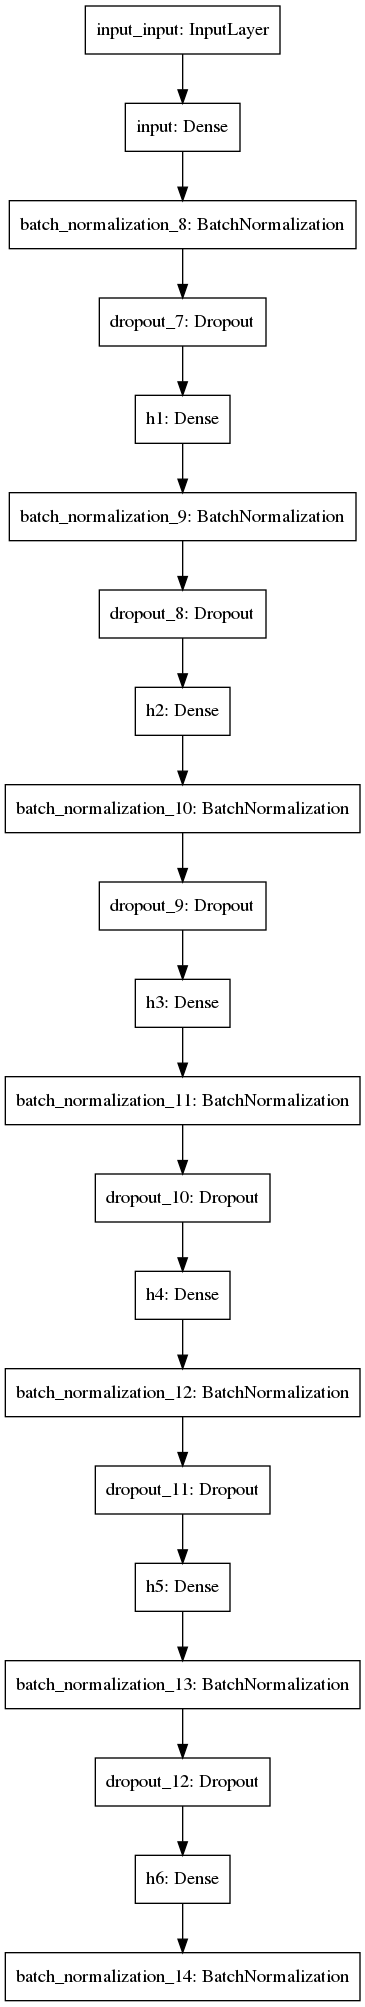

In [30]:
plot_model(accent_net, to_file='accent.png')

In [10]:
def get_both_embs(path):
        #for path in enumerate(train_dataset):
        _, accent_mfccs = get_accent_mfccs(path)
        speaker_mfccs = get_spectrogram_tisv(path)
        #print(accent_mfccs.shape)
        #print(speaker_mfccs.shape)
        speaker_mfccs = Variable(torch.from_numpy(speaker_mfccs)).to('cuda')
        speaker_emb = run_speaker_encoder(speaker_mfccs, embedder_net)
        #print(speaker_emb.shape)
        accent_emb = accent_net.predict(accent_mfccs)
        #print(accent_emb.shape)
        return speaker_emb.cpu().detach().numpy(), accent_emb

In [14]:
dataset = TripletSpeakerDataset()
data_loader = torch.utils.data.DataLoader(dataset, drop_last=True)

In [15]:
for batch_idx, (anchor_utter_path, positive_utter_path, negative_utter_path, accent_negative_path, speaker_positive_id, speaker_negative_id, speaker_anchor_id, positive_accent, negative_accent) in enumerate(data_loader):
    print(anchor_utter_path, positive_utter_path, negative_utter_path, accent_negative_path, speaker_positive_id, speaker_negative_id, speaker_anchor_id, positive_accent, negative_accent)

('data/American/p301/p301_410_mic1.flac',) ('data/American/p301/p301_280_mic1.flac',) ('data/American/p300/p300_314_mic2.flac',) ('data/Irish/p283/p283_255_mic1.flac',) ('p301',) ('p300',) ('p301',) ('American',) ('Irish',)
('data/Scottish/p249/p249_010_mic2.flac',) ('data/Scottish/p249/p249_137_mic2.flac',) ('data/Scottish/p284/p284_063_mic1.flac',) ('data/American/p299/p299_275_mic1.flac',) ('p249',) ('p284',) ('p249',) ('Scottish',) ('American',)
('data/American/p301/p301_179_mic1.flac',) ('data/American/p301/p301_265_mic2.flac',) ('data/American/p299/p299_160_mic2.flac',) ('data/Irish/p283/p283_425_mic2.flac',) ('p301',) ('p299',) ('p301',) ('American',) ('Irish',)
('data/American/p299/p299_371_mic2.flac',) ('data/American/p299/p299_370_mic2.flac',) ('data/American/p301/p301_095_mic2.flac',) ('data/Scottish/p234/p234_099_mic1.flac',) ('p299',) ('p301',) ('p299',) ('American',) ('Scottish',)
('data/Scottish/p249/p249_226_mic2.flac',) ('data/Scottish/p249/p249_077_mic1.flac',) ('data

('data/Irish/p283/p283_266_mic2.flac',) ('data/Irish/p283/p283_117_mic2.flac',) ('data/Irish/p298/p298_040_mic2.flac',) ('data/American/p299/p299_307_mic2.flac',) ('p283',) ('p298',) ('p283',) ('Irish',) ('American',)
('data/Irish/p245/p245_249_mic1.flac',) ('data/Irish/p245/p245_271_mic2.flac',) ('data/Irish/p283/p283_437_mic1.flac',) ('data/Indian/p376/p376_296_mic2.flac',) ('p245',) ('p283',) ('p245',) ('Irish',) ('Indian',)
('data/Scottish/p284/p284_384_mic1.flac',) ('data/Scottish/p284/p284_217_mic1.flac',) ('data/Scottish/p234/p234_354_mic1.flac',) ('data/American/p300/p300_263_mic1.flac',) ('p284',) ('p234',) ('p284',) ('Scottish',) ('American',)
('data/Scottish/p249/p249_265_mic1.flac',) ('data/Scottish/p249/p249_256_mic1.flac',) ('data/Scottish/p237/p237_020_mic1.flac',) ('data/Indian/p376/p376_193_mic1.flac',) ('p249',) ('p237',) ('p249',) ('Scottish',) ('Indian',)
('data/Irish/p245/p245_061_mic1.flac',) ('data/Irish/p245/p245_324_mic2.flac',) ('data/Irish/p295/p295_058_mic2.

('data/Scottish/p249/p249_168_mic1.flac',) ('data/Scottish/p249/p249_130_mic2.flac',) ('data/Scottish/p284/p284_248_mic2.flac',) ('data/American/p300/p300_030_mic2.flac',) ('p249',) ('p284',) ('p249',) ('Scottish',) ('American',)
('data/Indian/p376/p376_372_mic1.flac',) ('data/Indian/p376/p376_138_mic1.flac',) ('data/Indian/p251/p251_082_mic2.flac',) ('data/Scottish/p237/p237_311_mic2.flac',) ('p376',) ('p251',) ('p376',) ('Indian',) ('Scottish',)
('data/Indian/p376/p376_172_mic1.flac',) ('data/Indian/p376/p376_067_mic1.flac',) ('data/Indian/p251/p251_061_mic2.flac',) ('data/American/p299/p299_044_mic1.flac',) ('p376',) ('p251',) ('p376',) ('Indian',) ('American',)
('data/American/p300/p300_014_mic1.flac',) ('data/American/p300/p300_153_mic2.flac',) ('data/American/p301/p301_024_mic2.flac',) ('data/Irish/p245/p245_131_mic1.flac',) ('p300',) ('p301',) ('p300',) ('American',) ('Irish',)
('data/Indian/p251/p251_058_mic1.flac',) ('data/Indian/p251/p251_136_mic1.flac',) ('data/Indian/p248/p

('data/Scottish/p249/p249_050_mic2.flac',) ('data/Scottish/p249/p249_031_mic1.flac',) ('data/Scottish/p284/p284_224_mic1.flac',) ('data/Irish/p298/p298_120_mic2.flac',) ('p249',) ('p284',) ('p249',) ('Scottish',) ('Irish',)
('data/American/p301/p301_167_mic2.flac',) ('data/American/p301/p301_196_mic2.flac',) ('data/American/p300/p300_153_mic2.flac',) ('data/Indian/p251/p251_334_mic2.flac',) ('p301',) ('p300',) ('p301',) ('American',) ('Indian',)
('data/Indian/p248/p248_363_mic2.flac',) ('data/Indian/p248/p248_097_mic2.flac',) ('data/Indian/p251/p251_257_mic1.flac',) ('data/Irish/p283/p283_272_mic2.flac',) ('p248',) ('p251',) ('p248',) ('Indian',) ('Irish',)
('data/American/p300/p300_159_mic2.flac',) ('data/American/p300/p300_147_mic2.flac',) ('data/American/p299/p299_068_mic1.flac',) ('data/Scottish/p284/p284_374_mic1.flac',) ('p300',) ('p299',) ('p300',) ('American',) ('Scottish',)
('data/Indian/p251/p251_001_mic1.flac',) ('data/Indian/p251/p251_042_mic2.flac',) ('data/Indian/p248/p24

('data/Irish/p245/p245_073_mic2.flac',) ('data/Irish/p245/p245_026_mic1.flac',) ('data/Irish/p295/p295_013_mic1.flac',) ('data/Scottish/p237/p237_338_mic1.flac',) ('p245',) ('p295',) ('p245',) ('Irish',) ('Scottish',)
('data/Indian/p376/p376_015_mic2.flac',) ('data/Indian/p376/p376_289_mic2.flac',) ('data/Indian/p248/p248_078_mic1.flac',) ('data/American/p300/p300_179_mic1.flac',) ('p376',) ('p248',) ('p376',) ('Indian',) ('American',)
('data/Scottish/p234/p234_120_mic2.flac',) ('data/Scottish/p234/p234_197_mic1.flac',) ('data/Scottish/p249/p249_280_mic1.flac',) ('data/Indian/p376/p376_092_mic2.flac',) ('p234',) ('p249',) ('p234',) ('Scottish',) ('Indian',)
('data/American/p301/p301_179_mic2.flac',) ('data/American/p301/p301_214_mic2.flac',) ('data/American/p300/p300_270_mic2.flac',) ('data/Irish/p295/p295_176_mic1.flac',) ('p301',) ('p300',) ('p301',) ('American',) ('Irish',)
('data/American/p300/p300_263_mic1.flac',) ('data/American/p300/p300_247_mic1.flac',) ('data/American/p301/p30

('data/Irish/p295/p295_134_mic1.flac',) ('data/Irish/p295/p295_396_mic1.flac',) ('data/Irish/p283/p283_057_mic1.flac',) ('data/American/p301/p301_089_mic1.flac',) ('p295',) ('p283',) ('p295',) ('Irish',) ('American',)
('data/Indian/p251/p251_244_mic2.flac',) ('data/Indian/p251/p251_120_mic1.flac',) ('data/Indian/p376/p376_388_mic1.flac',) ('data/Scottish/p234/p234_139_mic1.flac',) ('p251',) ('p376',) ('p251',) ('Indian',) ('Scottish',)
('data/Scottish/p284/p284_240_mic2.flac',) ('data/Scottish/p284/p284_319_mic1.flac',) ('data/Scottish/p237/p237_204_mic2.flac',) ('data/Irish/p298/p298_188_mic2.flac',) ('p284',) ('p237',) ('p284',) ('Scottish',) ('Irish',)
('data/Indian/p248/p248_088_mic1.flac',) ('data/Indian/p248/p248_275_mic2.flac',) ('data/Indian/p251/p251_361_mic2.flac',) ('data/Scottish/p237/p237_173_mic1.flac',) ('p248',) ('p251',) ('p248',) ('Indian',) ('Scottish',)
('data/American/p299/p299_398_mic2.flac',) ('data/American/p299/p299_160_mic1.flac',) ('data/American/p300/p300_36

('data/Scottish/p249/p249_106_mic1.flac',) ('data/Scottish/p249/p249_134_mic1.flac',) ('data/Scottish/p237/p237_167_mic2.flac',) ('data/Irish/p283/p283_102_mic2.flac',) ('p249',) ('p237',) ('p249',) ('Scottish',) ('Irish',)
('data/Irish/p283/p283_413_mic1.flac',) ('data/Irish/p283/p283_469_mic2.flac',) ('data/Irish/p245/p245_167_mic1.flac',) ('data/Scottish/p284/p284_240_mic2.flac',) ('p283',) ('p245',) ('p283',) ('Irish',) ('Scottish',)
('data/Indian/p248/p248_356_mic2.flac',) ('data/Indian/p248/p248_138_mic1.flac',) ('data/Indian/p251/p251_328_mic1.flac',) ('data/Scottish/p249/p249_252_mic1.flac',) ('p248',) ('p251',) ('p248',) ('Indian',) ('Scottish',)
('data/Irish/p245/p245_311_mic1.flac',) ('data/Irish/p245/p245_181_mic1.flac',) ('data/Irish/p295/p295_078_mic2.flac',) ('data/Scottish/p284/p284_022_mic2.flac',) ('p245',) ('p295',) ('p245',) ('Irish',) ('Scottish',)
('data/Irish/p295/p295_241_mic1.flac',) ('data/Irish/p295/p295_419_mic2.flac',) ('data/Irish/p283/p283_018_mic1.flac',

('data/American/p299/p299_089_mic1.flac',) ('data/American/p299/p299_264_mic2.flac',) ('data/American/p300/p300_148_mic2.flac',) ('data/Indian/p376/p376_314_mic1.flac',) ('p299',) ('p300',) ('p299',) ('American',) ('Indian',)
('data/Scottish/p234/p234_019_mic2.flac',) ('data/Scottish/p234/p234_199_mic1.flac',) ('data/Scottish/p249/p249_022_mic2.flac',) ('data/Irish/p298/p298_295_mic1.flac',) ('p234',) ('p249',) ('p234',) ('Scottish',) ('Irish',)
('data/American/p300/p300_208_mic2.flac',) ('data/American/p300/p300_349_mic2.flac',) ('data/American/p299/p299_132_mic1.flac',) ('data/Scottish/p284/p284_079_mic2.flac',) ('p300',) ('p299',) ('p300',) ('American',) ('Scottish',)
('data/American/p299/p299_090_mic2.flac',) ('data/American/p299/p299_323_mic2.flac',) ('data/American/p300/p300_268_mic2.flac',) ('data/Irish/p295/p295_014_mic2.flac',) ('p299',) ('p300',) ('p299',) ('American',) ('Irish',)
('data/American/p300/p300_334_mic2.flac',) ('data/American/p300/p300_321_mic1.flac',) ('data/Ame

('data/Irish/p298/p298_091_mic2.flac',) ('data/Irish/p298/p298_111_mic1.flac',) ('data/Irish/p245/p245_240_mic2.flac',) ('data/Indian/p248/p248_179_mic2.flac',) ('p298',) ('p245',) ('p298',) ('Irish',) ('Indian',)
('data/Scottish/p237/p237_211_mic2.flac',) ('data/Scottish/p237/p237_214_mic1.flac',) ('data/Scottish/p234/p234_001_mic2.flac',) ('data/Indian/p251/p251_323_mic2.flac',) ('p237',) ('p234',) ('p237',) ('Scottish',) ('Indian',)
('data/American/p300/p300_137_mic1.flac',) ('data/American/p300/p300_108_mic2.flac',) ('data/American/p301/p301_221_mic2.flac',) ('data/Scottish/p237/p237_025_mic1.flac',) ('p300',) ('p301',) ('p300',) ('American',) ('Scottish',)
('data/Scottish/p249/p249_306_mic1.flac',) ('data/Scottish/p249/p249_239_mic1.flac',) ('data/Scottish/p284/p284_043_mic1.flac',) ('data/Irish/p298/p298_149_mic2.flac',) ('p249',) ('p284',) ('p249',) ('Scottish',) ('Irish',)
('data/Scottish/p234/p234_194_mic2.flac',) ('data/Scottish/p234/p234_167_mic2.flac',) ('data/Scottish/p284

('data/Indian/p251/p251_217_mic1.flac',) ('data/Indian/p251/p251_181_mic2.flac',) ('data/Indian/p376/p376_009_mic2.flac',) ('data/Irish/p245/p245_150_mic2.flac',) ('p251',) ('p376',) ('p251',) ('Indian',) ('Irish',)
('data/American/p300/p300_264_mic2.flac',) ('data/American/p300/p300_252_mic2.flac',) ('data/American/p301/p301_352_mic1.flac',) ('data/Irish/p245/p245_252_mic2.flac',) ('p300',) ('p301',) ('p300',) ('American',) ('Irish',)
('data/Indian/p376/p376_135_mic1.flac',) ('data/Indian/p376/p376_104_mic2.flac',) ('data/Indian/p248/p248_099_mic1.flac',) ('data/Irish/p245/p245_236_mic2.flac',) ('p376',) ('p248',) ('p376',) ('Indian',) ('Irish',)
('data/Irish/p298/p298_160_mic2.flac',) ('data/Irish/p298/p298_276_mic2.flac',) ('data/Irish/p295/p295_373_mic2.flac',) ('data/Indian/p248/p248_022_mic1.flac',) ('p298',) ('p295',) ('p298',) ('Irish',) ('Indian',)
('data/Irish/p298/p298_356_mic1.flac',) ('data/Irish/p298/p298_072_mic2.flac',) ('data/Irish/p295/p295_211_mic2.flac',) ('data/Ind

('data/Irish/p245/p245_018_mic1.flac',) ('data/Irish/p245/p245_006_mic2.flac',) ('data/Irish/p298/p298_040_mic1.flac',) ('data/Indian/p248/p248_112_mic1.flac',) ('p245',) ('p298',) ('p245',) ('Irish',) ('Indian',)
('data/American/p300/p300_204_mic2.flac',) ('data/American/p300/p300_228_mic2.flac',) ('data/American/p299/p299_330_mic1.flac',) ('data/Indian/p251/p251_132_mic1.flac',) ('p300',) ('p299',) ('p300',) ('American',) ('Indian',)
('data/Scottish/p249/p249_282_mic2.flac',) ('data/Scottish/p249/p249_082_mic2.flac',) ('data/Scottish/p234/p234_079_mic2.flac',) ('data/Irish/p245/p245_240_mic1.flac',) ('p249',) ('p234',) ('p249',) ('Scottish',) ('Irish',)
('data/Irish/p283/p283_189_mic2.flac',) ('data/Irish/p283/p283_392_mic2.flac',) ('data/Irish/p245/p245_304_mic2.flac',) ('data/Scottish/p284/p284_248_mic1.flac',) ('p283',) ('p245',) ('p283',) ('Irish',) ('Scottish',)
('data/American/p300/p300_024_mic2.flac',) ('data/American/p300/p300_170_mic2.flac',) ('data/American/p301/p301_339_mi

('data/Irish/p298/p298_324_mic1.flac',) ('data/Irish/p298/p298_310_mic1.flac',) ('data/Irish/p295/p295_328_mic2.flac',) ('data/Scottish/p284/p284_066_mic1.flac',) ('p298',) ('p295',) ('p298',) ('Irish',) ('Scottish',)
('data/Scottish/p249/p249_240_mic1.flac',) ('data/Scottish/p249/p249_189_mic1.flac',) ('data/Scottish/p284/p284_334_mic2.flac',) ('data/Indian/p376/p376_300_mic2.flac',) ('p249',) ('p284',) ('p249',) ('Scottish',) ('Indian',)
('data/Scottish/p234/p234_309_mic2.flac',) ('data/Scottish/p234/p234_336_mic1.flac',) ('data/Scottish/p284/p284_416_mic1.flac',) ('data/Indian/p376/p376_351_mic1.flac',) ('p234',) ('p284',) ('p234',) ('Scottish',) ('Indian',)
('data/Irish/p295/p295_155_mic2.flac',) ('data/Irish/p295/p295_303_mic1.flac',) ('data/Irish/p283/p283_276_mic1.flac',) ('data/American/p300/p300_365_mic2.flac',) ('p295',) ('p283',) ('p295',) ('Irish',) ('American',)
('data/Irish/p245/p245_029_mic1.flac',) ('data/Irish/p245/p245_309_mic2.flac',) ('data/Irish/p298/p298_373_mic2.

('data/Indian/p248/p248_177_mic1.flac',) ('data/Indian/p248/p248_277_mic2.flac',) ('data/Indian/p376/p376_172_mic2.flac',) ('data/American/p300/p300_136_mic1.flac',) ('p248',) ('p376',) ('p248',) ('Indian',) ('American',)
('data/Scottish/p237/p237_078_mic1.flac',) ('data/Scottish/p237/p237_232_mic2.flac',) ('data/Scottish/p284/p284_326_mic2.flac',) ('data/American/p300/p300_389_mic1.flac',) ('p237',) ('p284',) ('p237',) ('Scottish',) ('American',)
('data/Irish/p283/p283_032_mic2.flac',) ('data/Irish/p283/p283_040_mic1.flac',) ('data/Irish/p245/p245_184_mic1.flac',) ('data/Indian/p376/p376_186_mic1.flac',) ('p283',) ('p245',) ('p283',) ('Irish',) ('Indian',)
('data/Scottish/p237/p237_258_mic1.flac',) ('data/Scottish/p237/p237_208_mic2.flac',) ('data/Scottish/p284/p284_229_mic2.flac',) ('data/Indian/p376/p376_327_mic1.flac',) ('p237',) ('p284',) ('p237',) ('Scottish',) ('Indian',)
('data/Irish/p295/p295_175_mic1.flac',) ('data/Irish/p295/p295_126_mic1.flac',) ('data/Irish/p245/p245_043_m

('data/Indian/p251/p251_209_mic1.flac',) ('data/Indian/p251/p251_138_mic1.flac',) ('data/Indian/p248/p248_342_mic1.flac',) ('data/American/p300/p300_198_mic1.flac',) ('p251',) ('p248',) ('p251',) ('Indian',) ('American',)
('data/Scottish/p249/p249_005_mic2.flac',) ('data/Scottish/p249/p249_168_mic2.flac',) ('data/Scottish/p234/p234_212_mic1.flac',) ('data/American/p301/p301_402_mic2.flac',) ('p249',) ('p234',) ('p249',) ('Scottish',) ('American',)
('data/Irish/p283/p283_294_mic2.flac',) ('data/Irish/p283/p283_302_mic1.flac',) ('data/Irish/p298/p298_216_mic1.flac',) ('data/Indian/p376/p376_019_mic2.flac',) ('p283',) ('p298',) ('p283',) ('Irish',) ('Indian',)
('data/Irish/p283/p283_225_mic2.flac',) ('data/Irish/p283/p283_310_mic1.flac',) ('data/Irish/p245/p245_233_mic2.flac',) ('data/Scottish/p284/p284_357_mic2.flac',) ('p283',) ('p245',) ('p283',) ('Irish',) ('Scottish',)
('data/Irish/p295/p295_044_mic1.flac',) ('data/Irish/p295/p295_257_mic2.flac',) ('data/Irish/p298/p298_405_mic1.flac

('data/Irish/p245/p245_184_mic1.flac',) ('data/Irish/p245/p245_073_mic2.flac',) ('data/Irish/p283/p283_176_mic2.flac',) ('data/Indian/p376/p376_043_mic2.flac',) ('p245',) ('p283',) ('p245',) ('Irish',) ('Indian',)
('data/Irish/p283/p283_273_mic1.flac',) ('data/Irish/p283/p283_182_mic1.flac',) ('data/Irish/p298/p298_292_mic1.flac',) ('data/American/p301/p301_358_mic2.flac',) ('p283',) ('p298',) ('p283',) ('Irish',) ('American',)
('data/Scottish/p237/p237_195_mic2.flac',) ('data/Scottish/p237/p237_173_mic1.flac',) ('data/Scottish/p234/p234_260_mic2.flac',) ('data/Irish/p298/p298_314_mic1.flac',) ('p237',) ('p234',) ('p237',) ('Scottish',) ('Irish',)
('data/Scottish/p234/p234_082_mic1.flac',) ('data/Scottish/p234/p234_227_mic2.flac',) ('data/Scottish/p249/p249_167_mic1.flac',) ('data/American/p299/p299_161_mic1.flac',) ('p234',) ('p249',) ('p234',) ('Scottish',) ('American',)
('data/Indian/p376/p376_117_mic1.flac',) ('data/Indian/p376/p376_329_mic1.flac',) ('data/Indian/p251/p251_164_mic2

('data/Indian/p251/p251_369_mic1.flac',) ('data/Indian/p251/p251_050_mic2.flac',) ('data/Indian/p248/p248_090_mic2.flac',) ('data/Scottish/p237/p237_045_mic1.flac',) ('p251',) ('p248',) ('p251',) ('Indian',) ('Scottish',)
('data/Scottish/p284/p284_413_mic2.flac',) ('data/Scottish/p284/p284_061_mic1.flac',) ('data/Scottish/p234/p234_127_mic1.flac',) ('data/Indian/p251/p251_234_mic1.flac',) ('p284',) ('p234',) ('p284',) ('Scottish',) ('Indian',)
('data/Scottish/p249/p249_069_mic1.flac',) ('data/Scottish/p249/p249_127_mic1.flac',) ('data/Scottish/p237/p237_239_mic1.flac',) ('data/Irish/p245/p245_130_mic1.flac',) ('p249',) ('p237',) ('p249',) ('Scottish',) ('Irish',)
('data/American/p299/p299_092_mic2.flac',) ('data/American/p299/p299_189_mic2.flac',) ('data/American/p301/p301_232_mic1.flac',) ('data/Indian/p376/p376_170_mic2.flac',) ('p299',) ('p301',) ('p299',) ('American',) ('Indian',)
('data/Scottish/p234/p234_240_mic2.flac',) ('data/Scottish/p234/p234_290_mic2.flac',) ('data/Scottish/

KeyboardInterrupt: 

In [ ]:
speaker_positive_id[0], speaker_negative_id, speaker_anchor_id, positive_accent, negative_accent

In [ ]:
anchor_utter_path, positive_utter_path, negative_utter_path, accent_negative_path

In [16]:
class PairwiseDistance(Function):
    def __init__(self, p):
        super(PairwiseDistance, self).__init__()
        self.norm = p

    def forward(self, x1, x2):
        
        #print("above assert: ",x1, x2)
        assert x1.size() == x2.size()
        eps = 1e-4 / x1.size(1)
        diff = torch.abs(x1 - x2)
        out = torch.pow(diff, self.norm).sum(dim=1)
        return torch.pow(out + eps, 1. / self.norm)

class TripletLoss(Function):
    """
    Triplet loss function.
    """
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.pdist = PairwiseDistance(2)  # norm 2

    def forward(self, anchor, positive, negative):
        d_p = self.pdist.forward(torch.from_numpy(anchor), positive)
        d_n = self.pdist.forward(torch.from_numpy(anchor), torch.from_numpy(negative))

        dist_hinge = torch.clamp(self.margin + d_p - d_n, min=0.0)
        loss = torch.mean(dist_hinge)
        return loss

In [17]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.inp1 = nn.Linear(in_features=256, out_features=100)
        self.inp2 = nn.Linear(in_features=100, out_features=100)
        self.b_n = nn.BatchNorm1d(128)
        
        self.drop_out = nn.Dropout(0.25)
        self.l1 = nn.Linear(200, 128)
        self.l2 = nn.Linear(128,128)
        self.out_acc = nn.Linear(128, 100)
        self.out_speak = nn.Linear(128,256)
        
    def forward(self, *args):
        speaker_emb, acc_emb = args[0], args[1]
        x1 = F.relu(self.inp1(speaker_emb))
        
        x2 = F.relu(self.inp2(x1))
        #print(x1.shape, x2.shape, speaker_emb.shape, acc_emb.shape)
        out = torch.cat((x1, x2), axis=1)
        out = self.l1(out)
        out = F.relu(out)
        out = F.relu(self.l2(out))
        
        mf_acc = self.out_acc(out)
        mf_sp = self.out_speak(out)
        return F.relu(mf_sp), F.relu(mf_acc)

In [18]:
def train():
    device = hp.device
    dataset = TripletSpeakerDataset()
    data_loader = torch.utils.data.DataLoader(dataset, drop_last=True)
    ae = AutoEncoder().to('cuda')
    writer = SummaryWriter('triplet_loss_logs')
    optimizer = optim.Adam(ae.parameters())
    optimizer.zero_grad()
    #ae.load_state_dict(torch.load(''))
    trip_loss = TripletLoss()
    total_loss = 0
    for epoch in range(20):
        for batch_id, (anchor_utter_path, positive_utter_path, negative_utter_path, accent_negative_path, speaker_positive_id, speaker_negative_id, speaker_anchor_id, positive_accent, negative_accent) in tqdm(enumerate(data_loader), total = len(data_loader)):
            anchor_utter_path, positive_utter_path, negative_utter_path = anchor_utter_path[0], positive_utter_path[0], negative_utter_path[0]
            accent_negative_path, speaker_positive_id, speaker_negative_id = accent_negative_path[0], speaker_positive_id[0], speaker_negative_id[0]
            speaker_anchor_id, positive_accent, negative_accent = speaker_anchor_id[0], positive_accent[0], negative_accent[0]
            
            try:
                pre_positive_speaker_embs, pre_positive_accent_embs = get_both_embs(positive_utter_path)
                pre_positive_speaker_embs, pre_positive_accent_embs = Variable(torch.from_numpy(pre_positive_speaker_embs)).to('cuda'), Variable(torch.from_numpy(pre_positive_accent_embs)).to('cuda')
                anchor_utter_path
                anchor_speaker_embs, anchor_accent_embs = get_both_embs(anchor_utter_path)
                negative_speaker_embs, _ = get_both_embs(negative_utter_path)
                _, negative_accent_embs = get_both_embs(accent_negative_path)
            except ValueError:
                print("ValueError")
                continue
            except:
                continue
            positive_speaker_embs, positive_accent_embs = ae.forward(pre_positive_speaker_embs, pre_positive_accent_embs)
            positive_speaker_embs, positive_accent_embs = positive_speaker_embs.to('cpu'), positive_accent_embs.to('cpu')
            optimizer.zero_grad()
            #print(anchor_accent_embs.shape)
            accent_trip_loss = trip_loss.forward(anchor_accent_embs, positive_accent_embs, negative_accent_embs)
            speaker_trip_loss = trip_loss.forward(anchor_speaker_embs, positive_speaker_embs, negative_speaker_embs)
            criterion = accent_trip_loss + speaker_trip_loss
            total_loss += criterion
            
            
            
            criterion.backward()
            optimizer.step()
            writer.add_scalar('Loss', criterion, epoch*len(data_loader)+1)
            
            if (batch_id + 1) % 5 == 0:
                mesg = "{}\tEpoch:{},Iteration:{}\tLoss:{}\t\n".format(time.ctime(), epoch+1,
                        batch_id+1, criterion)
                print(mesg)
                if hp.train.log_file is not None:
                    with open(hp.train.log_file,'a') as f:
                        f.write(mesg)
            if hp.train.checkpoint_dir is not None and (batch_id + 1) % 100 == 0:
                ae.eval()
                ckpt_model_filename = "ckpt_epoch_" + str(batch_id+1) + "_batch_id_" + str(batch_id+1) + ".pth"
                ckpt_model_path = os.path.join("new_checkpoints/", ckpt_model_filename)
                torch.save(ae.state_dict(), ckpt_model_path)
                ae.to(device).train()
        ae.eval()
        save_model_filename = "final_epoch_" + str(epoch + 1) + "_batch_id_" + str(batch_id + 1) + ".model"
        save_model_path = os.path.join(hp.train.checkpoint_dir, save_model_filename)
        torch.save(ae.state_dict(), save_model_path)

        print("\nDone, trained model saved at", save_model_path)

In [14]:
train()

NameError: name 'train' is not defined

In [19]:
len(data_loader)

10956

In [52]:
from __future__ import print_function
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.manifold import TSNE
import time
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
def preprocess_tsne(model, path):
    tsne = TSNE(verbose=1)
    utters = []
    files = glob.glob(path)
    speakers = []
    X1=[]
    for i,file in enumerate(files):
        if i%50!=0:
            continue
        try:
            pre_positive_speaker_embs, pre_positive_accent_embs = get_both_embs(file)
        except:
            print('continuing')
            continue
        speaker = file.split('/')[-2]
        pre_positive_speaker_embs, pre_positive_accent_embs = Variable(torch.from_numpy(pre_positive_speaker_embs)).to('cpu'), Variable(torch.from_numpy(pre_positive_accent_embs)).to('cpu')
        utt, _ = ae.forward(pre_positive_speaker_embs, pre_positive_accent_embs)
        print(i)
        utters.append(utt)
        speakers.append(speaker)
        X1.append(get_spectrogram_tisv(file))
    arr = [t.detach().numpy() for t in utters]
    y = np.asarray(speakers)
    print(speakers)
    print(np.asarray(arr).shape)
    X = np.squeeze(np.asarray(arr), 1)
    return X, y, X1


def tsne_visualize(X, y):
    feat_cols = ['pixel'+str(i) for i in range(X.shape[1])]
    df = pd.DataFrame(X,columns=feat_cols)
    df['y'] = y
    df['label'] = df['y'].apply(lambda i: str(i))
    print('Size of the dataframe: {}'.format(df.shape))
    
    np.random.seed(42)
    rndperm = np.random.permutation(df.shape[0])
    
    N = 10000
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(df[feat_cols].values)
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1] 
    df['pca-three'] = pca_result[:,2]
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    plt.figure(figsize=(16,10))
    sns_plot = sns.scatterplot(
        x="pca-one", y="pca-two",
        hue="y",
        palette=sns.color_palette("hls", 14),
        data=df.loc[rndperm,:],
        legend="full",
        alpha=1.0
    )
    sns_plot.figure.savefig('fig.png')
    #plt.savefig("out.png")
    df_subset = df.loc[rndperm[:N],:].copy()
    data_subset = df_subset[feat_cols].values
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=10000)
    print(X.shape)
    tsne_results = tsne.fit_transform(pd.DataFrame(np.asarray(X)))
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
    plt.figure(figsize=(16,10))
    """
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls", 14),
        data=df_subset,
        legend="brief"
    )
    """

In [69]:
hp.data.train_path

'./data/*/*/*.flac'

In [70]:
hp.data.train_path

'./data/*/*/*.flac'

In [71]:
ae = AutoEncoder().to('cpu')
ae.load_state_dict(torch.load("./new_checkpoints/ckpt_epoch_5_batch_id_8000.pth")['state_dict'])
X, y ,specs= preprocess_tsne(ae, hp.data.train_path)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
Not long enough
continuing
9950
1

In [72]:
len(y)

218

Size of the dataframe: (218, 258)
Explained variation per principal component: [0.55593807 0.2320815  0.08744882]
(218, 256)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 218 samples in 0.000s...
[t-SNE] Computed neighbors for 218 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 218 / 218
[t-SNE] Mean sigma: 0.064460
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.870892
[t-SNE] KL divergence after 2100 iterations: 0.073837
t-SNE done! Time elapsed: 1.079143762588501 seconds


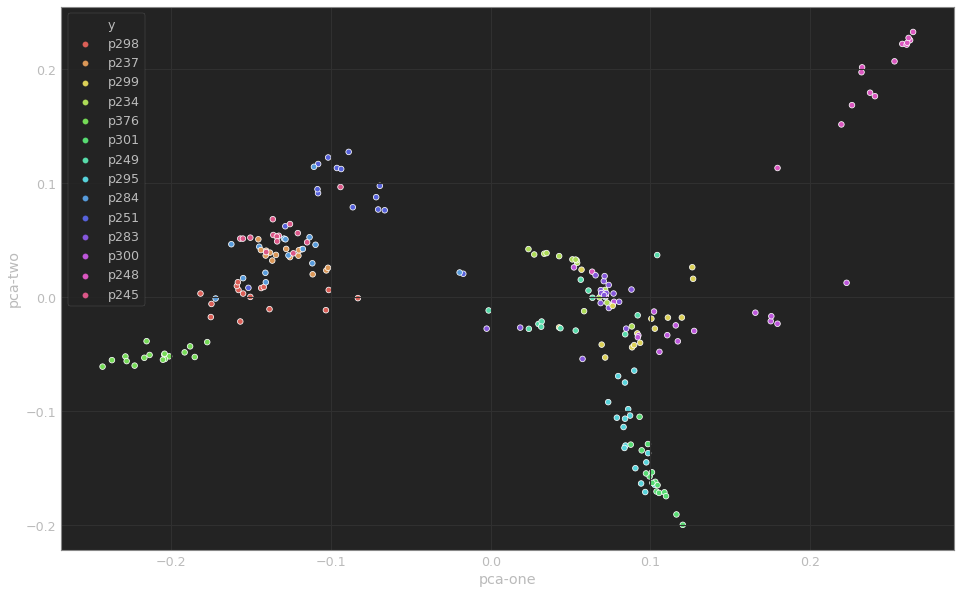

<Figure size 1152x720 with 0 Axes>

In [73]:
tsne_visualize(X, y)

Size of the dataframe: (22, 7202)
Explained variation per principal component: [0.14826806 0.11645931 0.08877328]
(22, 7200)
[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 22 samples in 0.000s...
[t-SNE] Computed neighbors for 22 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 22 / 22
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.575615
[t-SNE] KL divergence after 1700 iterations: 0.425569
t-SNE done! Time elapsed: 0.2778158187866211 seconds


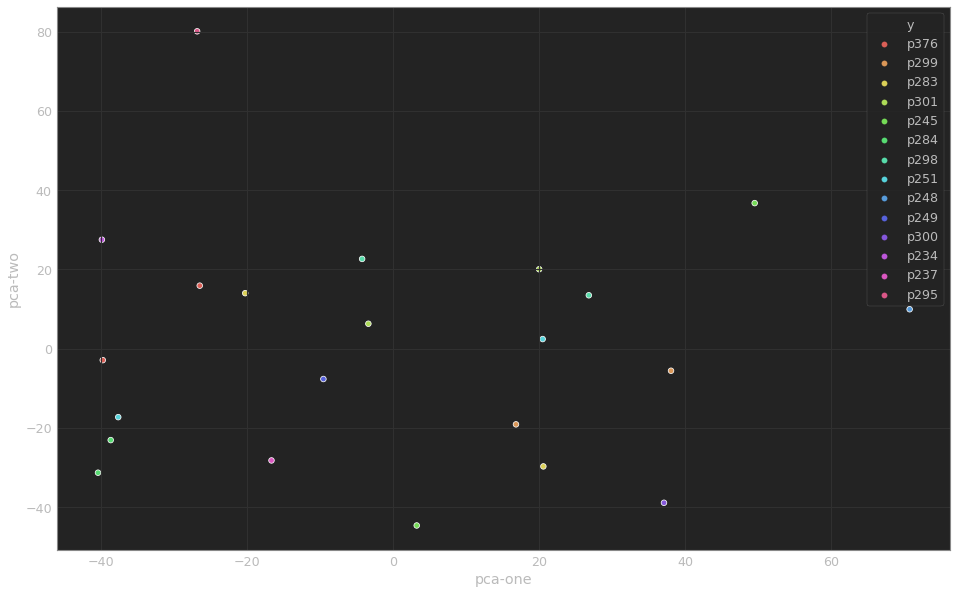

<Figure size 1152x720 with 0 Axes>

In [39]:
tsne_visualize(np.asarray(specs).reshape(np.asarray(specs).shape[0], -1), y)

In [40]:
X1.reshape(X1.shape[0], -1).shape

NameError: name 'X1' is not defined

In [41]:
y.shape

(22,)

Size of the dataframe: (22, 258)
Explained variation per principal component: [0.6140105  0.22361195 0.07259732]
(22, 256)
[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 22 samples in 0.000s...
[t-SNE] Computed neighbors for 22 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 22 / 22
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.551815
[t-SNE] KL divergence after 900 iterations: 0.425877
t-SNE done! Time elapsed: 0.18427348136901855 seconds


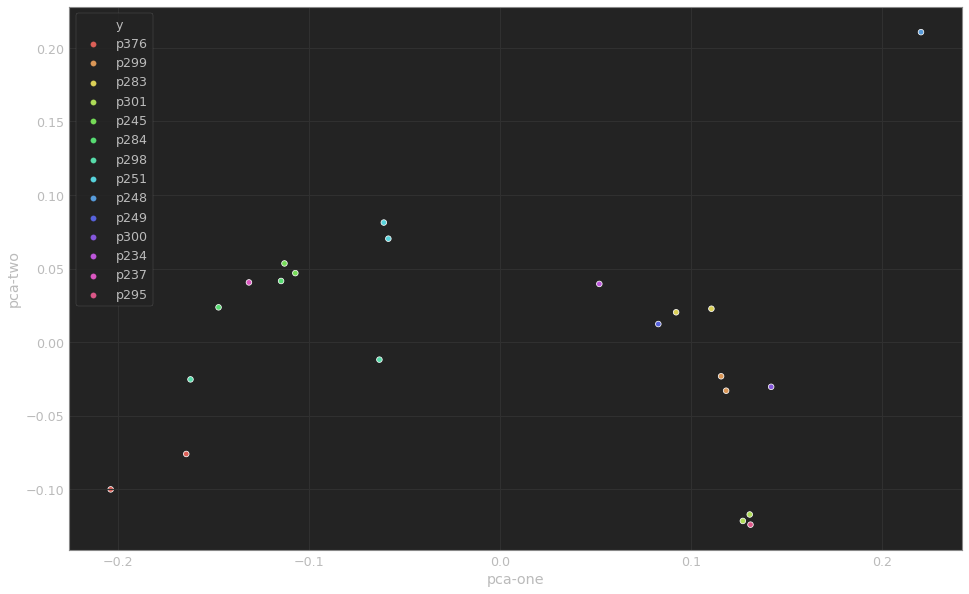

<Figure size 1152x720 with 0 Axes>

In [42]:
tsne_visualize(X, y)

Size of the dataframe: (22, 258)
Explained variation per principal component: [0.6140105  0.22361195 0.07259732]
(22, 256)
[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 22 samples in 0.000s...
[t-SNE] Computed neighbors for 22 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 22 / 22
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.551819
[t-SNE] KL divergence after 900 iterations: 0.425877
t-SNE done! Time elapsed: 0.16087889671325684 seconds


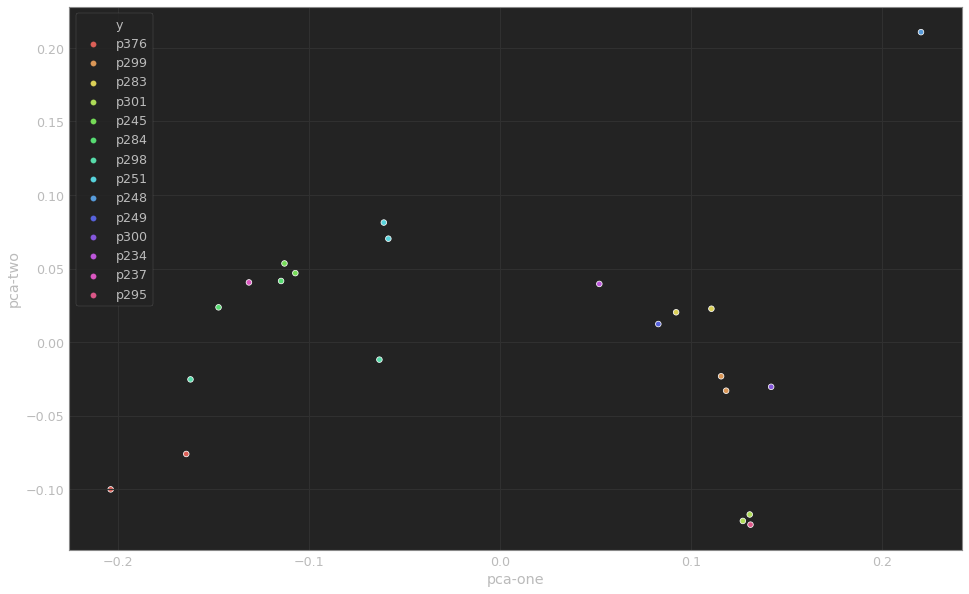

<Figure size 1152x720 with 0 Axes>

In [43]:
tsne_visualize(X, y)

Size of the dataframe: (22, 258)
Explained variation per principal component: [0.6140105  0.22361195 0.07259732]
(22, 256)
[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 22 samples in 0.000s...
[t-SNE] Computed neighbors for 22 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 22 / 22
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.551819
[t-SNE] KL divergence after 900 iterations: 0.425877
t-SNE done! Time elapsed: 0.14165544509887695 seconds


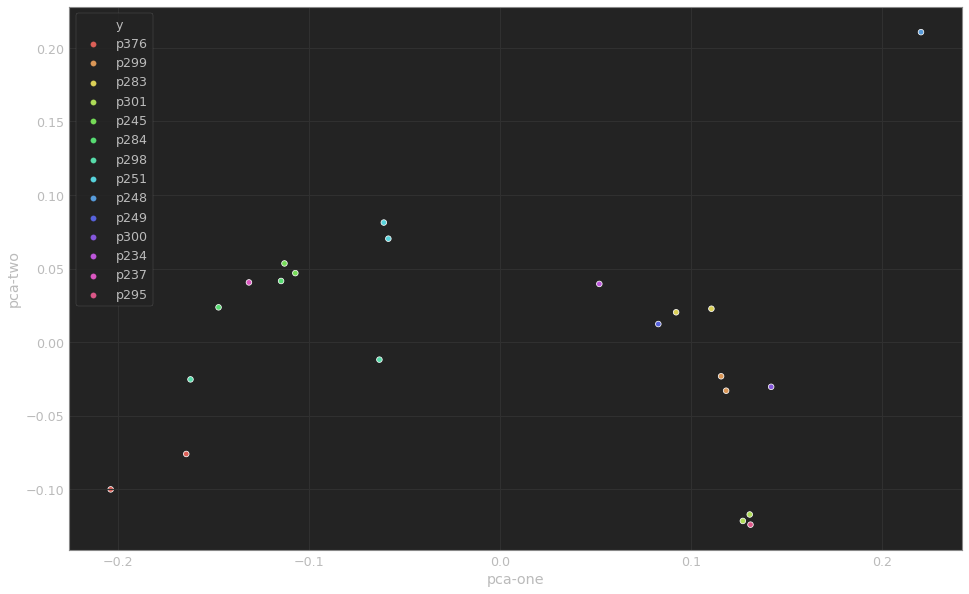

<Figure size 1152x720 with 0 Axes>

In [44]:
tsne_visualize(X, y)

Size of the dataframe: (22, 258)
Explained variation per principal component: [0.6140105  0.22361195 0.07259732]
(22, 256)
[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 22 samples in 0.000s...
[t-SNE] Computed neighbors for 22 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 22 / 22
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.551819
[t-SNE] KL divergence after 900 iterations: 0.425877
t-SNE done! Time elapsed: 0.15058016777038574 seconds


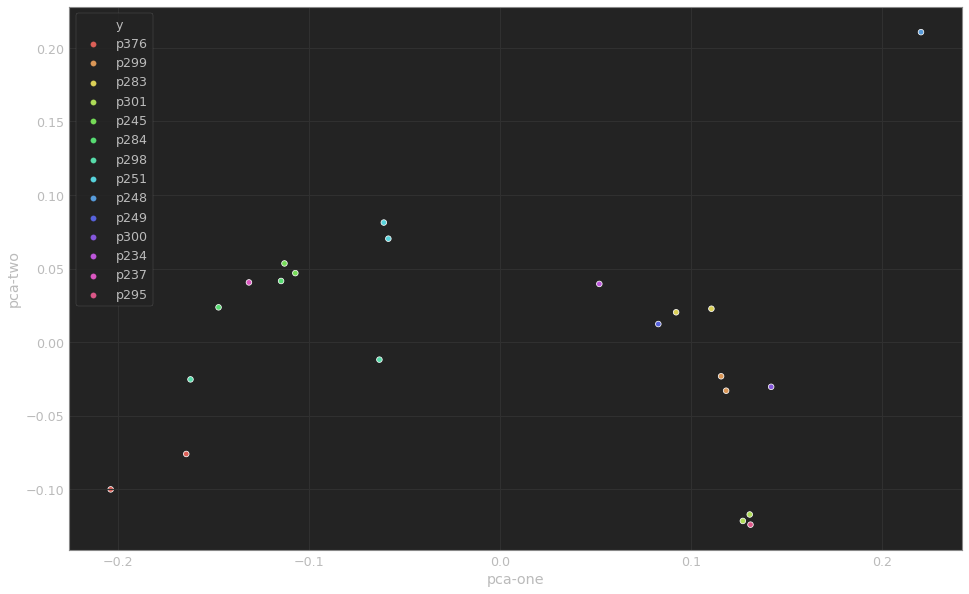

<Figure size 1152x720 with 0 Axes>

In [49]:
tsne_visualize(X, y)

In [59]:
pca = PCA(n_components=3)

array([[ 2.02909393e+01, -2.64707127e+01, -1.99331703e+01],
       [-4.98939544e-01, -1.47841825e+01,  1.67141380e+01],
       [ 5.49169769e+01,  1.36487017e+01,  1.15841913e+01],
       [ 6.68065414e+01,  1.83504999e+00,  2.51923442e+00],
       [ 6.16068382e+01,  1.56751931e+00, -1.18767560e+00],
       [ 1.58490543e+01, -1.73385601e+01,  1.57831848e+00],
       [ 1.59853637e+00, -6.33093834e+00,  2.97420998e+01],
       [ 2.30127163e+01, -1.98130322e+01,  2.56670551e+01],
       [ 3.43278275e+01, -1.07816935e+01,  5.86195135e+00],
       [-7.10167456e+00, -2.30731049e+01, -2.44185886e+01],
       [-2.86180520e+00,  2.15116615e+01,  8.75409222e+00],
       [-2.77860088e+01, -1.91719761e+01,  4.96013689e+00],
       [-1.40560369e+01,  2.83372669e+01, -7.53189707e+00],
       [-3.00184536e+01,  1.04009686e+01, -2.08259945e+01],
       [-2.50758915e+01, -2.28281555e+01, -2.81658821e+01],
       [-1.97043324e+01, -1.60979786e+01, -1.89660492e+01],
       [-2.59778862e+01, -2.39029713e+01

In [64]:
import torchviz

In [68]:
pre_positive_speaker_embs, pre_positive_accent_embs = get_both_embs(file_name)
pre_positive_speaker_embs, pre_positive_accent_embs = Variable(torch.from_numpy(pre_positive_speaker_embs)).to('cpu'), Variable(torch.from_numpy(pre_positive_accent_embs)).to('cpu')


RuntimeError: size mismatch, m1: [1 x 100], m2: [256 x 100] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:136

In [69]:
pre_positive_accent_embs.shape

torch.Size([1, 100])

In [70]:
pre_positive_speaker_embs.shape

torch.Size([1, 256])

In [10]:
from pytorch2keras.converter import pytorch_to_keras

DEBUG:graphviz.backend:run ['dot', '-Tsvg']


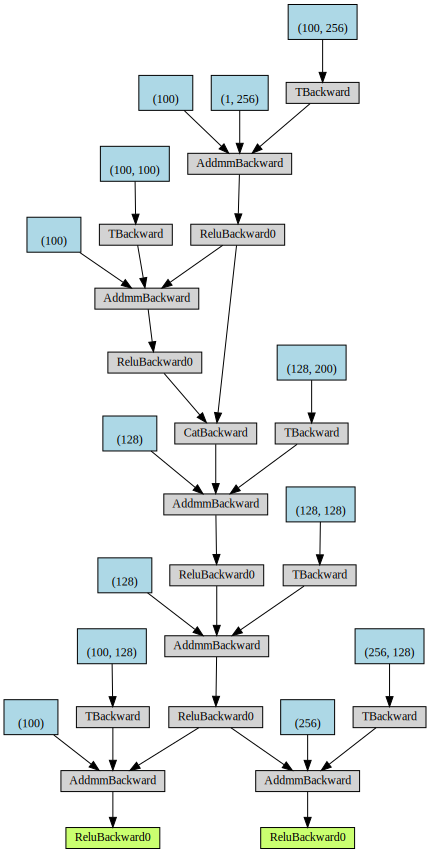

In [33]:
x1 = torch.zeros(1,100, dtype=torch.float, requires_grad=True)
x2 = torch.zeros(1,256, dtype=torch.float, requires_grad=True)
ae = AutoEncoder()
out = ae.forward(x2,x1)
torchviz.make_dot(out)

In [90]:
pytorch_total_params = sum(p.numel() for p in ae.parameters() if p.requires_grad)

In [91]:
pytorch_total_params

124220

In [32]:
import onnx
import torchviz

In [28]:
x1 = torch.randn(batch_size, 1, 100, requires_grad=True)
x1 = torch.randn(batch_size, 1, 256, requires_grad=True)


NameError: name 'batch_size' is not defined

In [34]:
torch.onnx.export(ae,
          (x1,x2),
          'test.onnx',
          export_params=True)

RuntimeError: size mismatch, m1: [1 x 100], m2: [256 x 100] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:136

In [48]:
%matplotlib.use('Agg')

UsageError: Line magic function `%matplotlib.use('Agg')` not found.
